In [1]:

# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier as lbgm
from catboost import CatBoostClassifier as cb
from xgboost import XGBClassifier as xgbc
from interpret.glassbox import ExplainableBoostingClassifier
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv('telecom_churn.csv')
data=data.head(100000)
print('Initial shape:', data.shape)
print('Columns:', list(data.columns))
display(data.head())

Initial shape: (100000, 14)
Columns: ['customer_id', 'telecom_partner', 'gender', 'age', 'state', 'city', 'pincode', 'date_of_registration', 'num_dependents', 'estimated_salary', 'calls_made', 'sms_sent', 'data_used', 'churn']


,customer_id,telecom_partner,gender,age,state,city,pincode,date_of_registration,num_dependents,estimated_salary,calls_made,sms_sent,data_used,churn
0,1,Reliance Jio,F,25,Karnataka,Kolkata,755597,2020-01-01,4,124962,44,45,-361,0
1,2,Reliance Jio,F,55,Mizoram,Mumbai,125926,2020-01-01,2,130556,62,39,5973,0
2,3,Vodafone,F,57,Arunachal Pradesh,Delhi,423976,2020-01-01,0,148828,49,24,193,1
3,4,BSNL,M,46,Tamil Nadu,Kolkata,522841,2020-01-01,1,38722,80,25,9377,1
4,5,BSNL,F,26,Tripura,Delhi,740247,2020-01-01,2,55098,78,15,1393,0


# DATA CLEANING

In [3]:
# basic cleaning & ID removal
data = data.drop(columns=['customer_id'], errors='ignore')
data = data.drop(columns=['pincode'], errors='ignore')
data = data.drop(columns=['date_of_registration'], errors='ignore')
    
data = data.drop_duplicates().copy()

print('Shape after dropping IDs & duplicates:', data.shape)

Shape after dropping IDs & duplicates: (100000, 11)


## fOR TARGET

In [4]:
# target column standardization (churn)
target_col = 'churn'  # in this dataset the target is 'churn'

# Convert to numeric if necessary
mapping = {"Yes":1,"No":0,"yes":1,"no":0,"Y":1,"N":0,"y":1,"n":0,"YES":1,"N0":0}
if data[target_col].dtype == object:
    data[target_col] = data[target_col].map(mapping)

data[target_col] = pd.to_numeric(data[target_col], errors='coerce')
data[target_col] = data[target_col].astype(int)

data = data.dropna(subset=[target_col]).copy()

print('Target distribution:')
print(data[target_col].value_counts(normalize=False))


Target distribution:
churn
0    80035
1    19965
Name: count, dtype: int64


## FOR FEATURES

In [ ]:
# fix negative / suspicious values for columns that should be only positive
usage_cols = [c for c in ['calls_made','sms_sent','data_used','age','num_dependents'] if c in data.columns]

for c in usage_cols:
    neg_count = (data[c] < 0).sum()
    if neg_count > 0:
        print(f'Column {c} has {neg_count} negative values. Setting to NaN and imputing median.')
        data.loc[data[c] < 0, c] = np.nan

#filling missing values with mean or me
for col in data.columns:
    if data[col].isnull().any():
        if np.issubdtype(data[col].dtype, np.number):
            # Impute numeric columns with median
            data[col] = data[col].fillna(data[col].median())
        else:
            # Impute categorical columns with mode
            data[col] = data[col].fillna(data[col].mode().iloc[0])

print('Remaining missing values total:', data.isnull().sum().sum())


Column calls_made has 2757 negative values. Setting to NaN and imputing median.
Column sms_sent has 2982 negative values. Setting to NaN and imputing median.
Column data_used has 2396 negative values. Setting to NaN and imputing median.
Remaining missing values total: 0


# DATA PREPROCESING

In [6]:
# encode categorical columns
le = LabelEncoder()
encoded_cols = []
for col in data.columns:
    data[col] = le.fit_transform(data[col].astype(str))
    encoded_cols.append(col)
print('columns encoded:', encoded_cols)


columns encoded: ['telecom_partner', 'gender', 'age', 'state', 'city', 'num_dependents', 'estimated_salary', 'calls_made', 'sms_sent', 'data_used', 'churn']


In [ ]:
# Feature Engineering - add derived behavioral features
if {'calls_made', 'sms_sent', 'data_used'}.issubset(data.columns):
    data["usage_intensity"] = (data["calls_made"] + data["sms_sent"]) / (data["data_used"].replace(0, np.nan))
    data["avg_data_per_call"] = data["data_used"] / (data["calls_made"].replace(0, np.nan))
    data["salary_to_usage_ratio"] = data["estimated_salary"] / (data["data_used"] + 1)

new_features = [
    "usage_intensity",
    "avg_data_per_call",
    "salary_to_usage_ratio"
]
print("Added new engineered features:", [c for c in data.columns if c in new_features])

# Replace any infinite values(values divided by 0) with NA
data = data.replace([np.inf, -np.inf], np.nan)


# 3. Verify (Optional: only needed if you want to see the result)
print(data.isnull().sum())



data

telecom_partner          0
gender                   0
age                      0
state                    0
city                     0
num_dependents           0
estimated_salary         0
calls_made               0
sms_sent                 0
data_used                0
churn                    0
usage_intensity          0
avg_data_per_call        0
salary_to_usage_ratio    0
dtype: int64
Added new engineered features: ['usage_intensity', 'avg_data_per_call', 'salary_to_usage_ratio']


,telecom_partner,gender,age,state,city,num_dependents,estimated_salary,calls_made,sms_sent,data_used,churn,usage_intensity,avg_data_per_call,salary_to_usage_ratio
0,2,0,7,10,4,4,13444,48,40,5368,0,0.016393,111.833333,2.504004
1,2,0,37,16,5,2,16453,68,33,6325,0,0.015968,93.014706,2.600854
2,3,0,39,1,2,0,26254,53,17,1833,1,0.038189,34.584906,14.315158
3,1,1,28,22,4,1,36970,88,18,10106,1,0.010489,114.840909,3.657861
4,1,0,8,24,2,2,45731,85,7,1237,0,0.074373,14.552941,36.939418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0,0,8,4,0,0,3314,22,53,4906,0,0.015287,223.000000,0.675362
99996,2,1,41,17,2,1,55747,84,44,10100,1,0.012673,120.238095,5.518959
99997,1,0,23,6,3,1,4053,69,33,7638,1,0.013354,110.695652,0.530567
99998,1,1,35,10,1,0,27771,48,15,9332,0,0.006751,194.416667,2.975571


In [8]:
# prepare data for ML (fixed for datetime column issue)

# Separate features (X) and target (y)
X = data.drop(columns=[target_col])
y = data[target_col]

# Now scale only numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and testing sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train1.shape, "Test shape:", X_test1.shape)


Train shape: (80000, 13) Test shape: (20000, 13)


In [9]:
# Apply SMOTE to handle class imbalance
from imblearn.over_sampling import SMOTE

print("\nBefore SMOTE:")
print(y_train1.value_counts())

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train1, y_train1)
X_test, y_test = smote.fit_resample(X_test1, y_test1)

print("\nAfter SMOTE:")
print(y_train.value_counts())


Before SMOTE:
churn
0    64028
1    15972
Name: count, dtype: int64

After SMOTE:
churn
0    64028
1    64028
Name: count, dtype: int64


## MODEL BUILDING

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

models = {
    'Gradient Boost': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
    'XGBoost': xgbc(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM': lbgm(n_estimators=100, random_state=42),
    'CatBoost': cb(iterations=100, verbose=0, random_state=42),
}


=== Training: Gradient Boost ===
Accuracy: 0.8341
              precision    recall  f1-score   support

           0      0.751     1.000     0.858     16007
           1      1.000     0.668     0.801     16007

    accuracy                          0.834     32014
   macro avg      0.875     0.834     0.829     32014
weighted avg      0.875     0.834     0.829     32014



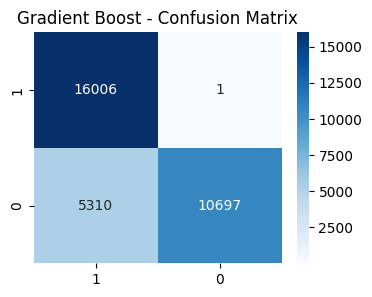


=== Training: XGBoost ===
Accuracy: 0.8661
              precision    recall  f1-score   support

           0      0.790     0.998     0.882     16007
           1      0.998     0.734     0.846     16007

    accuracy                          0.866     32014
   macro avg      0.894     0.866     0.864     32014
weighted avg      0.894     0.866     0.864     32014



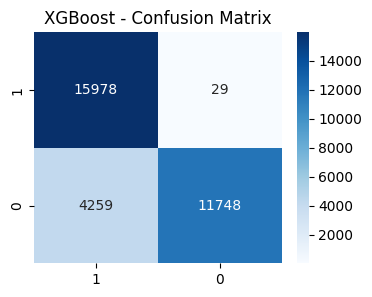


=== Training: LightGBM ===
[LightGBM] [Info] Number of positive: 64028, number of negative: 64028
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3098
[LightGBM] [Info] Number of data points in the train set: 128056, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Accuracy: 0.8718
              precision    recall  f1-score   support

           0      0.796     1.000     0.886     16007
           1      1.000     0.744     0.853     16007

    accuracy                          0.872     32014
   macro avg      0.898     0.872     0.870     32014
weighted avg      0.898     0.872     0.870     32014



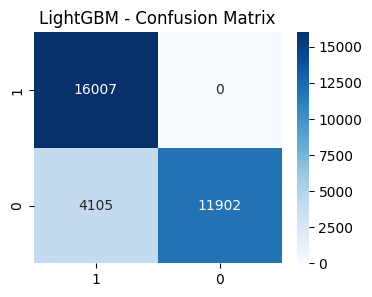


=== Training: CatBoost ===
Accuracy: 0.8726
              precision    recall  f1-score   support

           0      0.797     1.000     0.887     16007
           1      1.000     0.745     0.854     16007

    accuracy                          0.873     32014
   macro avg      0.898     0.873     0.870     32014
weighted avg      0.898     0.873     0.870     32014



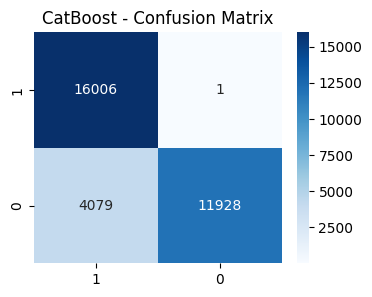

In [11]:
# training & evaluation
from sklearn.metrics import log_loss, roc_curve, auc

results = {}
losses = {}
roc_info = {}

for name, model in models.items():
    print('\n=== Training:', name, '===')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)[:,1]
    else:
        y_proba = y_pred  # fallback for models without predict_proba

    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    try:
        losses[name] = log_loss(y_test, y_proba)
    except Exception:
        losses[name] = None

    print('Accuracy:', round(acc,4))
    print(classification_report(y_test, y_pred, digits=3))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[1,0], yticklabels=[1,0])
    plt.title(f'{name} - Confusion Matrix')
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    roc_info[name] = (fpr, tpr, roc_auc)


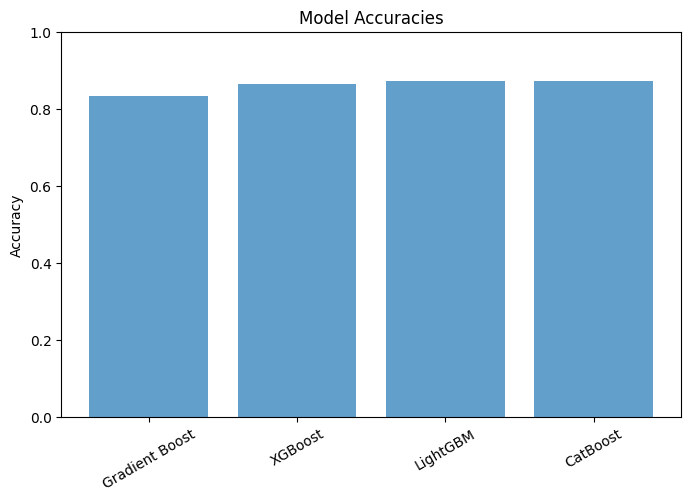

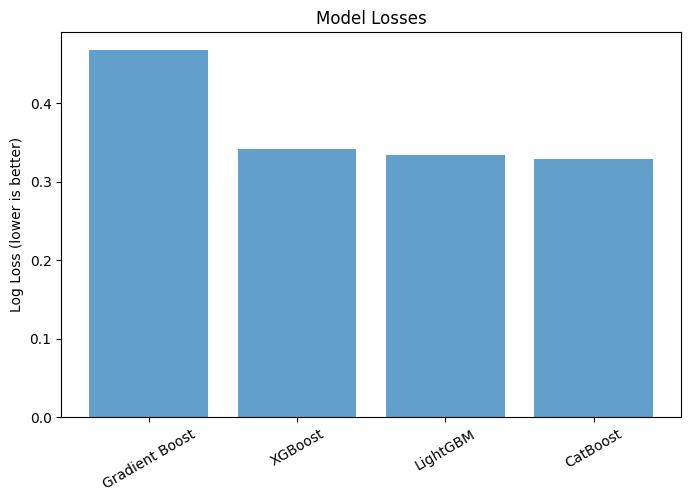

Results:
Gradient Boost: Accuracy=0.834, Loss=0.4673988732875428
XGBoost: Accuracy=0.866, Loss=0.3418597910400863
LightGBM: Accuracy=0.872, Loss=0.33433174196482
CatBoost: Accuracy=0.873, Loss=0.3292971334168374


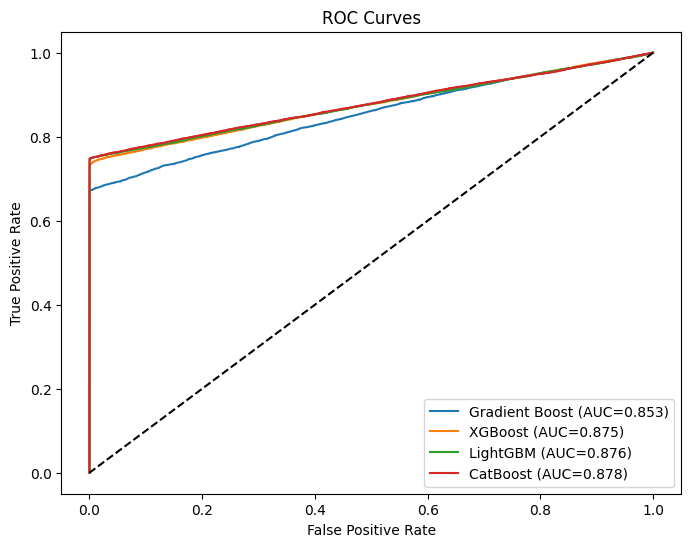

In [12]:

# results comparison & ROC curves
plt.figure(figsize=(8,5))
plt.bar(results.keys(), results.values(), alpha=0.7)
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.title('Model Accuracies')
plt.xticks(rotation=30)
plt.show()

plt.figure(figsize=(8,5))
plt.bar([k for k in losses.keys()], [l if l is not None else 0 for l in losses.values()], alpha=0.7)
plt.ylabel('Log Loss (lower is better)')
plt.title('Model Losses')
plt.xticks(rotation=30)
plt.show()

print('Results:')
for n in results:
    print(f"{n}: Accuracy={results[n]:.3f}, Loss={losses[n]}")

plt.figure(figsize=(8,6))
for name,(fpr,tpr,roc_auc) in roc_info.items():
    plt.plot(fpr,tpr,label=f"{name} (AUC={roc_auc:.3f})")
plt.plot([1,0],[1,0],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()


## ENSEMBLING

--- Starting Ensemble Search (Soft Voting) ---
Combination: ('Gradient Boost', 'XGBoost') - Accuracy: 0.8674
Combination: ('Gradient Boost', 'LightGBM') - Accuracy: 0.8715
Combination: ('Gradient Boost', 'CatBoost') - Accuracy: 0.8720
Combination: ('XGBoost', 'LightGBM') - Accuracy: 0.8723
Combination: ('XGBoost', 'CatBoost') - Accuracy: 0.8722
Combination: ('LightGBM', 'CatBoost') - Accuracy: 0.8721
Combination: ('Gradient Boost', 'XGBoost', 'LightGBM') - Accuracy: 0.8718
Combination: ('Gradient Boost', 'XGBoost', 'CatBoost') - Accuracy: 0.8716
Combination: ('Gradient Boost', 'LightGBM', 'CatBoost') - Accuracy: 0.8720
Combination: ('XGBoost', 'LightGBM', 'CatBoost') - Accuracy: 0.8724
Combination: ('Gradient Boost', 'XGBoost', 'LightGBM', 'CatBoost') - Accuracy: 0.8721

Best Soft Voting Ensemble Score: 0.8724
Best Model Combination: ['XGBoost', 'LightGBM', 'CatBoost']

=== Best Ensemble Model Results ===
Accuracy: 0.8724
              precision    recall  f1-score   support

         

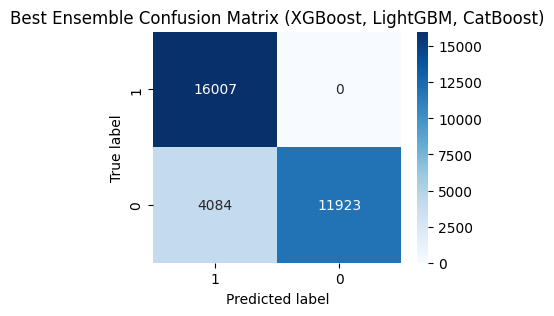

In [ ]:
import itertools
# Import all required libraries
from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier as xgbc
from lightgbm import LGBMClassifier as lbgm
from catboost import CatBoostClassifier as cb
from interpret.glassbox import ExplainableBoostingClassifier 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Data and Model Definitions (Placeholders) ---
# NOTE: You MUST ensure X_train, y_train, X_test, y_test are defined before this code runs.
# Also, ensure 'xgbc', 'lbgm', and 'cb' are correctly aliased from their imported classes.

# Assuming your 5 models are in a dictionary/list like this:
estimators_full = {
    'Gradient Boost': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
    'XGBoost': xgbc(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM': lbgm(n_estimators=100, random_state=42),
    'CatBoost': cb(iterations=100, verbose=0, random_state=42),
}

best_score = 0
best_combination_names = [] # Store names for final output
y_pred_best = None # Store predictions of the best model

# --- Ensemble Search Loop ---

print("--- Starting Ensemble Search (Soft Voting) ---")
# Iterate through combinations of size 2 up to 4 (since EBM is excluded, size is 4)
for k in range(2, len(estimators_full) + 1):
    # Get all combinations of size k (e.g., 2-model, 3-model, etc.)
    for combination_names in itertools.combinations(estimators_full.keys(), k):
        
        # Build the estimator list for the current combination
        current_estimators = [(name, estimators_full[name]) for name in combination_names]
        
        # Create and train the ensemble
        ensemble = VotingClassifier(estimators=current_estimators, voting='soft', n_jobs=-1)
        ensemble.fit(X_train, y_train)
        
        # Evaluate on the validation/test set
        y_pred = ensemble.predict(X_test)
        score = accuracy_score(y_test, y_pred)
        
        # Keep track of the best one
        if score > best_score:
            best_score = score
            best_combination_names = list(combination_names)
            y_pred_best = y_pred.copy()
            
        print(f"Combination: {combination_names} - Accuracy: {score:.4f}")

# --- Final Results using the BEST Combination ---

if y_pred_best is None:
    print("\nError: No combinations were tested or data variables are missing.")
else:
    print("\n==============================================")
    print(f"Best Soft Voting Ensemble Score: {round(best_score, 4)}")
    print(f"Best Model Combination: {best_combination_names}")
    print("==============================================")

    # Use the best predictions (y_pred_best) and the test labels (y_test)
    print("\n=== Best Ensemble Model Results ===")
    print("Accuracy:", round(accuracy_score(y_test, y_pred_best), 4))
    print(classification_report(y_test, y_pred_best, digits=3))

    # --- Confusion Matrix Plot for the BEST Ensemble ---
    cm = confusion_matrix(y_test, y_pred_best)
    
    # Create a descriptive title for the confusion matrix
    title_names = ", ".join(best_combination_names)
    
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['1','0'], yticklabels=['1','0'])
    plt.title(f'Best Ensemble Confusion Matrix ({title_names})')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
## HYPERPARAMETER TUNING

--- Starting Hyperparameter Tuning ---

--- Tuning Gradient Boost ---
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for Gradient Boost: {'learning_rate': 0.29156581270472504, 'max_depth': 4, 'n_estimators': 241, 'subsample': 0.996884623716487}
Test Accuracy for Tuned Gradient Boost: 0.8725
              precision    recall  f1-score   support

           0       0.80      1.00      0.89     16007
           1       1.00      0.75      0.85     16007

    accuracy                           0.87     32014
   macro avg       0.90      0.87      0.87     32014
weighted avg       0.90      0.87      0.87     32014



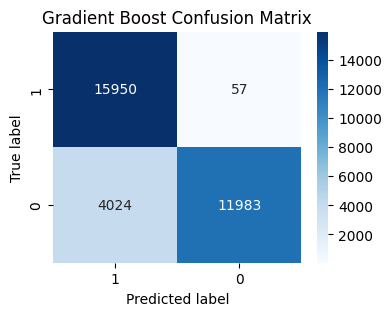


--- Tuning XGBoost ---
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for XGBoost: {'gamma': 0.18727005942368125, 'learning_rate': 0.2952142919229748, 'max_depth': 5, 'min_child_weight': 8, 'n_estimators': 238}
Test Accuracy for Tuned XGBoost: 0.8695
              precision    recall  f1-score   support

           0       0.79      1.00      0.88     16007
           1       1.00      0.74      0.85     16007

    accuracy                           0.87     32014
   macro avg       0.90      0.87      0.87     32014
weighted avg       0.90      0.87      0.87     32014



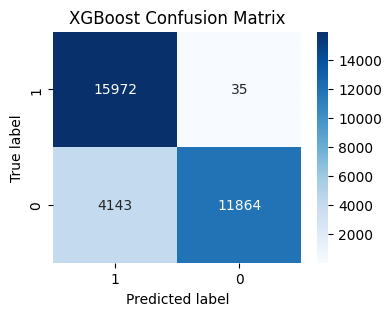


--- Tuning LightGBM ---
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Info] Number of positive: 64028, number of negative: 64028
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3098
[LightGBM] [Info] Number of data points in the train set: 128056, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Best parameters for LightGBM: {'colsample_bytree': 0.9439761626945282, 'learning_rate': 0.2140922615763339, 'max_depth': 13, 'n_estimators': 216, 'num_leaves': 37}
Test Accuracy for Tuned LightGBM: 0.8722
              precision    recall  f1-score   support

           0       0.80      1.00      0.89     16007
           1       1.00      0.75      0.85     16007

    accuracy                           0.87     32014
   macro avg       0.90      0.87      0.87     320

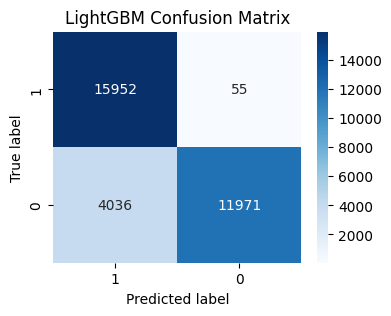


--- Tuning CatBoost ---
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for CatBoost: {'depth': 6, 'iterations': 199, 'l2_leaf_reg': 1.3948810531897018, 'learning_rate': 0.22659963168004743}
Test Accuracy for Tuned CatBoost: 0.8730
              precision    recall  f1-score   support

           0       0.80      1.00      0.89     16007
           1       1.00      0.75      0.85     16007

    accuracy                           0.87     32014
   macro avg       0.90      0.87      0.87     32014
weighted avg       0.90      0.87      0.87     32014



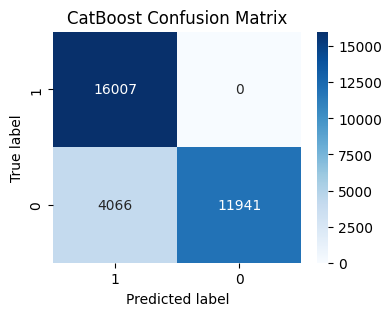


--- Final Tuned Ensemble Setup ---

=== Final Tuned Ensemble Results (Soft Voting) ===
Accuracy: 0.8738
              precision    recall  f1-score   support

           0      0.798     1.000     0.888     16007
           1      1.000     0.748     0.856     16007

    accuracy                          0.874     32014
   macro avg      0.899     0.874     0.872     32014
weighted avg      0.899     0.874     0.872     32014



In [17]:
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import VotingClassifier

# NOTE: The variable 'models' (your base models dictionary), 'X_train', 'y_train', 
# and 'X_test' must be defined in your environment for this code to run.

param_grids = {
    
    'Gradient Boost': {
        'n_estimators': randint(50, 300),
        'learning_rate': uniform(0.01, 0.3),
        'max_depth': randint(3, 8),
        'subsample': uniform(0.6, 0.4)
    },
    
    'XGBoost': {
        'n_estimators': randint(50, 300),
        'learning_rate': uniform(0.01, 0.3),
        'max_depth': randint(3, 10),
        'min_child_weight': randint(1, 10),
        'gamma': uniform(0, 0.5)
    },
    
    'LightGBM': {
        'n_estimators': randint(50, 300),
        'learning_rate': uniform(0.01, 0.3),
        'num_leaves': randint(20, 60),
        'max_depth': randint(5, 15),
        'colsample_bytree': uniform(0.6, 0.4)
    },
    
    'CatBoost': {
        'iterations': randint(50, 300),
        'learning_rate': uniform(0.01, 0.3),
        'depth': randint(4, 10),
        'l2_leaf_reg': uniform(1, 7)
    }
} # Fixed dictionary structure: removed extra braces/comments

# --- 4. Tuning Loop ---
tuned_models = {}
n_iter = 10 # Number of parameter settings that are sampled (adjust based on compute power)
cv_folds = 5 # Number of cross-validation folds

print("--- Starting Hyperparameter Tuning ---")

for name, model in models.items():
    print(f"\n--- Tuning {name} ---")
    
    # 4.1 Perform RandomizedSearchCV
    rscv = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grids[name],
        n_iter=n_iter,
        cv=cv_folds,
        scoring='f1', # Use 'f1' or another preferred metric from your analysis
        random_state=42,
        n_jobs=-1, # Use all cores
        verbose=1
    )
    
    rscv.fit(X_train, y_train)
    
    # 4.2 Store the best model and evaluate
    best_model = rscv.best_estimator_
    tuned_models[name] = best_model
    
    y_pred_tuned = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred_tuned)
    
    print(f"Best parameters for {name}: {rscv.best_params_}")
    print(f"Test Accuracy for Tuned {name}: {accuracy:.4f}")
    print(classification_report(y_test, y_pred_tuned))

    cm1 = confusion_matrix(y_test, y_pred_tuned)

    plt.figure(figsize=(4,3))
    sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues',xticklabels=['1','0'],yticklabels=['1','0'])
    plt.title(f'{name} Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# --- 5. Ensemble Setup with Tuned Models ---
print("\n--- Final Hyperparameter Tuned Setup ---")

# Prepare the estimators list for the VotingClassifier
ensemble_estimators = [(name, model) for name, model in tuned_models.items()]

# Ensure SVC/EBM/etc can output probabilities for 'soft' voting
# (Note: EBM and all the GBTs here support predict_proba)

final_ensemble = VotingClassifier(
    estimators=ensemble_estimators,
    voting='soft',
    n_jobs=-1 # Use all cores for ensemble
)

final_ensemble.fit(X_train, y_train)
y_pred_ensemble = final_ensemble.predict(X_test)

print("\n=== Final Tuned Ensemble Results (Soft Voting) ===")
print("Accuracy:", round(accuracy_score(y_test, y_pred_ensemble), 4))
print(classification_report(y_test, y_pred_ensemble, digits=3))